## Exploratory Data Analysis (EDA)

## Dataset Overview
 This data holds hundreds of thousands of traffic crash records reported by the.
Since 2017, the E-Crash system of Chicago Police Department. Each row represents
one reported traffic accident, with time and place information.
conditions, road environment and injury outcomes.

This analysis is aimed at investigating the crash distribution, analyzing the target.
variable (injury occurrence), and determine the patterns in key features prior to modelling.

In [40]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


In [41]:
#loading the dataset
df = pd.read_csv("Traffic_Crashes_-_Crashes.csv",low_memory=False)
df.head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,012c5bfce715efb2f2b387d6dd86f9c13e9dc1809fb52a...,JG341943,NaN,07/12/2023 03:05:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,...,0.0,0.0,2.0,0.0,15,4,7,41.778542,-87.742065,POINT (-87.742064741348 41.778541938106)
1,01d457f032e23d935a0b8f6b4c88221375180ffd4cd959...,JG338388,NaN,07/12/2023 05:50:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,...,0.0,0.0,2.0,0.0,17,4,7,41.742131,-87.721824,POINT (-87.72182410033 41.742130554062)
2,02249b4747a4bf40b88a8357304a98dfeaef9c38eebbf0...,JG350008,NaN,07/12/2023 02:00:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,OTHER OBJECT,...,0.0,0.0,1.0,0.0,14,4,7,41.719844,-87.584790,POINT (-87.584789974824 41.719844228292)
3,03e3b6caad71b78ed9ae325648effa9512bfb2517aed30...,JG338049,NaN,07/12/2023 07:05:00 AM,30,TRAFFIC SIGNAL,UNKNOWN,FREEZING RAIN/DRIZZLE,DAYLIGHT,REAR END,...,0.0,0.0,2.0,0.0,7,4,7,41.925105,-87.668291,POINT (-87.668291181568 41.925104953308)
4,0481fc919b38f1572d4ba04b069766102d904a662ff096...,JG338431,NaN,07/12/2023 06:30:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,...,0.0,0.0,2.0,0.0,18,4,7,41.975258,-87.751991,POINT (-87.751990557158 41.97525809527)


In [42]:
#inspecting data types and missing values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746498 entries, 0 to 746497
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                746498 non-null  object 
 1   RD_NO                          742191 non-null  object 
 2   CRASH_DATE_EST_I               56389 non-null   object 
 3   CRASH_DATE                     746498 non-null  object 
 4   POSTED_SPEED_LIMIT             746498 non-null  int64  
 5   TRAFFIC_CONTROL_DEVICE         746498 non-null  object 
 6   DEVICE_CONDITION               746498 non-null  object 
 7   WEATHER_CONDITION              746498 non-null  object 
 8   LIGHTING_CONDITION             746498 non-null  object 
 9   FIRST_CRASH_TYPE               746498 non-null  object 
 10  TRAFFICWAY_TYPE                746498 non-null  object 
 11  LANE_CNT                       199004 non-null  float64
 12  ALIGNMENT                     

### Data Cleaning and Preparation

Handling missing values, dropping unwanted columns and encoding categorical variables.

In [43]:
### selecting Relevant Columns for Analysis
cols = [
'PRIM_CONTRIBUTORY_CAUSE',
'WEATHER_CONDITION',
'LIGHTING_CONDITION',
'ROADWAY_SURFACE_COND',
'POSTED_SPEED_LIMIT',
'CRASH_HOUR',
'CRASH_DAY_OF_WEEK'
]


df = df[cols].dropna()

In [44]:
#dropping irrelevant columns
df.drop(columns=["CRASH_RECORD_ID", "LOCATION"], inplace=True, errors="ignore")
df.head()

,PRIM_CONTRIBUTORY_CAUSE,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,POSTED_SPEED_LIMIT,CRASH_HOUR,CRASH_DAY_OF_WEEK
0,IMPROPER TURNING/NO SIGNAL,CLEAR,DAYLIGHT,UNKNOWN,30,15,4
1,FOLLOWING TOO CLOSELY,CLEAR,DAYLIGHT,DRY,30,17,4
2,NOT APPLICABLE,CLEAR,DAYLIGHT,DRY,30,14,4
3,FOLLOWING TOO CLOSELY,FREEZING RAIN/DRIZZLE,DAYLIGHT,UNKNOWN,30,7,4
4,FOLLOWING TOO CLOSELY,CLEAR,DAYLIGHT,WET,30,18,4


In [45]:
#handling missing values
# Fill categorical nulls with “Unknown”
for col in df.select_dtypes("object"):
    df[col] = df[col].fillna("Unknown")

# Fill numeric nulls with median
for col in df.select_dtypes("number"):
    df[col] = df[col].fillna(df[col].median())


### Binning Rare Classes

In [46]:
# Reducing class imbalance and stabalizing model training.
top_causes = df['PRIM_CONTRIBUTORY_CAUSE'].value_counts().nlargest(8).index


df['CAUSE_BINNED'] = df['PRIM_CONTRIBUTORY_CAUSE'].where(
df['PRIM_CONTRIBUTORY_CAUSE'].isin(top_causes),
'OTHER'
)


df['CAUSE_BINNED'].value_counts()

CAUSE_BINNED
UNABLE TO DETERMINE                       288466
OTHER                                     137941
FAILING TO YIELD RIGHT-OF-WAY              81696
FOLLOWING TOO CLOSELY                      73697
NOT APPLICABLE                             39424
IMPROPER OVERTAKING/PASSING                36534
FAILING TO REDUCE SPEED TO AVOID CRASH     31598
IMPROPER BACKING                           29988
IMPROPER LANE USAGE                        27154
Name: count, dtype: int64

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746498 entries, 0 to 746497
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   PRIM_CONTRIBUTORY_CAUSE  746498 non-null  object
 1   WEATHER_CONDITION        746498 non-null  object
 2   LIGHTING_CONDITION       746498 non-null  object
 3   ROADWAY_SURFACE_COND     746498 non-null  object
 4   POSTED_SPEED_LIMIT       746498 non-null  int64 
 5   CRASH_HOUR               746498 non-null  int64 
 6   CRASH_DAY_OF_WEEK        746498 non-null  int64 
 7   CAUSE_BINNED             746498 non-null  object
dtypes: int64(3), object(5)
memory usage: 45.6+ MB


In [48]:
#check duplicates
df.duplicated().sum()

np.int64(620110)

In [49]:
# dropping duplicates
df = df.drop_duplicates()



In [50]:
#checking missing values again
df.isnull().sum()

PRIM_CONTRIBUTORY_CAUSE    0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
ROADWAY_SURFACE_COND       0
POSTED_SPEED_LIMIT         0
CRASH_HOUR                 0
CRASH_DAY_OF_WEEK          0
CAUSE_BINNED               0
dtype: int64

In [51]:
df.isnull().sum()

PRIM_CONTRIBUTORY_CAUSE    0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
ROADWAY_SURFACE_COND       0
POSTED_SPEED_LIMIT         0
CRASH_HOUR                 0
CRASH_DAY_OF_WEEK          0
CAUSE_BINNED               0
dtype: int64

## Crash Distribution by Hour of Day
This histogram shows how crashes are distributed across the 24-hour day.

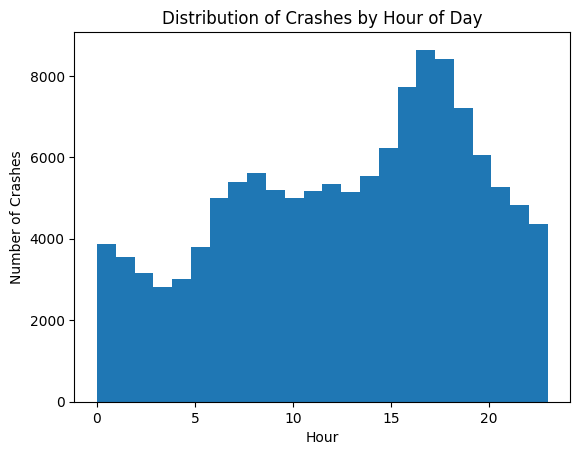

In [52]:
df['CRASH_HOUR'].dropna().plot(kind='hist', bins=24)
plt.title('Distribution of Crashes by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Crashes')
plt.show()


### Target Variable : Injury Occurred
Created a binary target variable which indicates whether a crash resulted in at least one injury.

In [53]:
#checking injury related columns
df.columns = df.columns.str.strip()

print([col for col in df.columns if 'INJURIES' in col])



[]


In [54]:
injury_cols = [
    'INJURIES_FATAL',
    'INJURIES_INCAPACITATING',
    'INJURIES_NON_INCAPACITATING',
    'INJURIES_REPORTED_NOT_EVIDENT'
]


In [55]:
injury_cols_in_df = [col for col in df.columns if "INJURIES" in col.upper()]
print(injury_cols_in_df)


[]


In [56]:
['INJURIES_FATAL',
 'INJURIES_INCAPACITATING',
 'INJURIES_NON_INCAPACITATING',
 'INJURIES_REPORTED_NOT_EVIDENT',
 'INJURIES_NO_INDICATION',
 'INJURIES_UNKNOWN']


['INJURIES_FATAL',
 'INJURIES_INCAPACITATING',
 'INJURIES_NON_INCAPACITATING',
 'INJURIES_REPORTED_NOT_EVIDENT',
 'INJURIES_NO_INDICATION',
 'INJURIES_UNKNOWN']

In [57]:
valid_injury_cols = [
    'INJURIES_FATAL',
    'INJURIES_INCAPACITATING',
    'INJURIES_NON_INCAPACITATING',
    'INJURIES_REPORTED_NOT_EVIDENT'
]


In [58]:
valid_injury_cols = [col for col in injury_cols_in_df if "NO_INDICATION" not in col and "UNKNOWN" not in col]
print(valid_injury_cols)


[]


In [59]:
df['Injury_Occurred'] = (df[valid_injury_cols].sum(axis=1) > 0).astype(int)


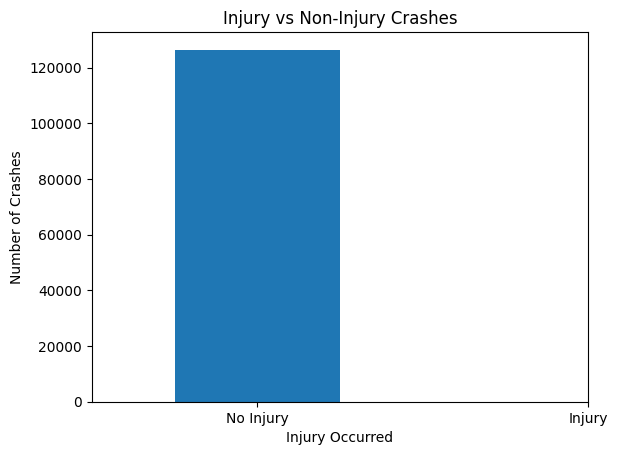

In [60]:
#creating a target variable
df["Injury_Occurred"].value_counts().plot(kind='bar')
plt.title("Injury vs Non-Injury Crashes")
plt.xlabel("Injury Occurred")
plt.ylabel("Number of Crashes")
plt.xticks([0, 1], ['No Injury', 'Injury'], rotation=0)
plt.show()


### Key Features Distributions
The bar chart below highlights the most common weather conditions during reported crashes.

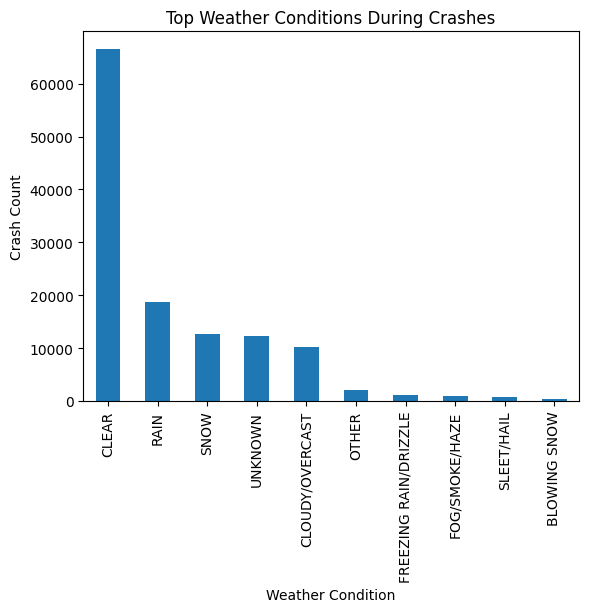

In [61]:
## Weather Condition Distribution
df['WEATHER_CONDITION'].value_counts().head(10).plot(kind='bar')
plt.title("Top Weather Conditions During Crashes")
plt.xlabel("Weather Condition")
plt.ylabel("Crash Count")
plt.show()


### Primary Contributory Cause Distribution
This visualization shows the most frequent primary contributory causes prior to binning.

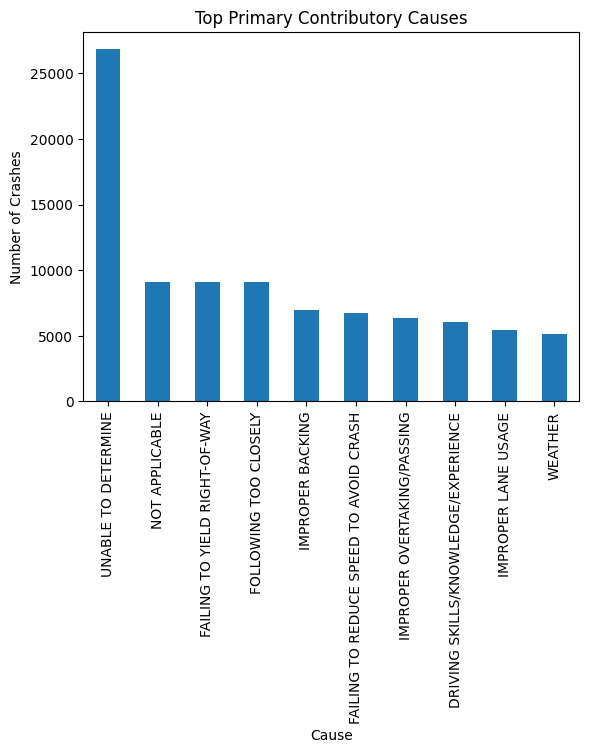

In [62]:
df['PRIM_CONTRIBUTORY_CAUSE'].value_counts().head(10).plot(kind='bar')
plt.title('Top Primary Contributory Causes')
plt.xlabel('Cause')
plt.ylabel('Number of Crashes')
plt.show()

### Target Variable Distribution
Many contributory causes have very few observations, which motivates binning rare classes.

In [63]:
# Displaying the top 10 primary contributory causes
df['PRIM_CONTRIBUTORY_CAUSE'].value_counts().head(10)

PRIM_CONTRIBUTORY_CAUSE
UNABLE TO DETERMINE                       26809
NOT APPLICABLE                             9136
FAILING TO YIELD RIGHT-OF-WAY              9101
FOLLOWING TOO CLOSELY                      9093
IMPROPER BACKING                           6929
FAILING TO REDUCE SPEED TO AVOID CRASH     6717
IMPROPER OVERTAKING/PASSING                6391
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE        6040
IMPROPER LANE USAGE                        5450
WEATHER                                    5131
Name: count, dtype: int64

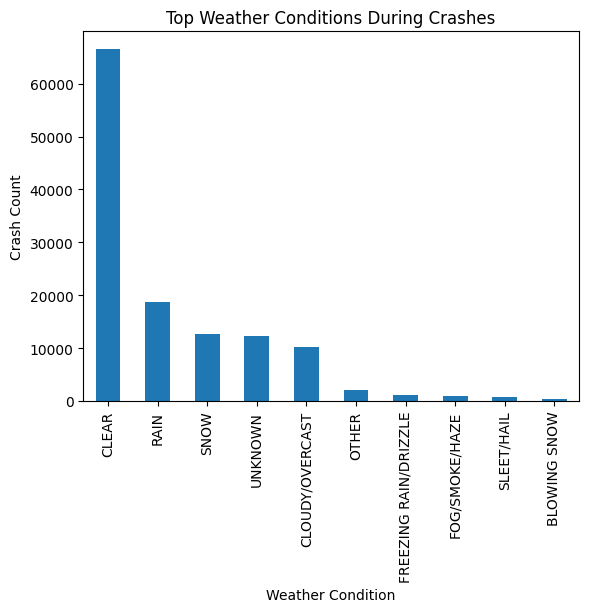

In [64]:
## Weather Condition Distribution
df['WEATHER_CONDITION'].value_counts().head(10).plot(kind='bar')
plt.title('Top Weather Conditions During Crashes')
plt.xlabel('Weather Condition')
plt.ylabel('Crash Count')
plt.show()

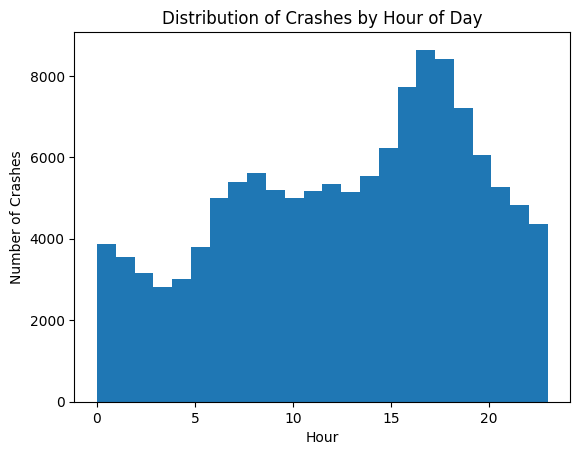

In [65]:
## Crash Hour Distribution
df['CRASH_HOUR'].plot(kind='hist', bins=24)
plt.title("Distribution of Crashes by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Crashes")
plt.show()


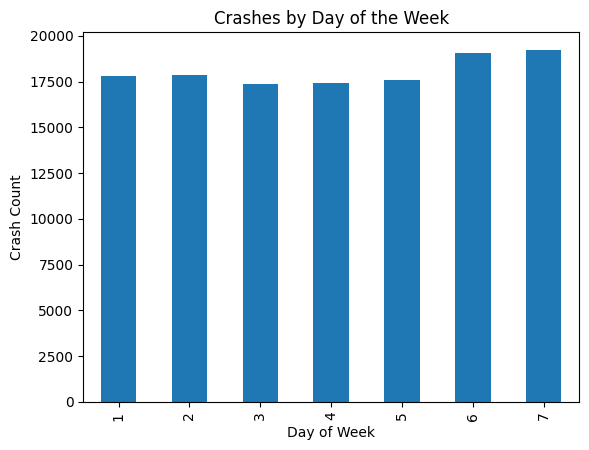

In [66]:
## Day of Week Distribution
df['CRASH_DAY_OF_WEEK'].value_counts().sort_index().plot(kind='bar')
plt.title("Crashes by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Crash Count")
plt.show()


### Monitoring Patterns and Trends.
There are a few trends based on the exploration analysis. The highest frequency of crash is at.
midday and early evening and this would coincide with the times that the traffic volume is high.
The majority of the crashes are experienced during normal weather conditions like clear or cloudy weather,
implicating weather as not the key concept that determines the occurrence of crashes.

A large percentage of crashes relate to lower set speed limits (25-35 mph).
representative of the urban driving conditions. However, in general, time and traffic-related.
factors are found to have a greater influence in the crash frequency as compared to adverse weather.
conditions.

### Feature Definition and Train-Test Split

In [67]:
target_column = 'PRIM_CONTRIBUTORY_CAUSE' 
X = df.drop(columns=[target_column])
y = df[target_column]

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

#  Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

## Preprocessing Pipeline

In [68]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_features = [
'WEATHER_CONDITION',
'LIGHTING_CONDITION',
'ROADWAY_SURFACE_COND'
]


numeric_features = [
'POSTED_SPEED_LIMIT',
'CRASHHOUR',
'CRASHDAYOFWEEK'
]


preprocessor = ColumnTransformer(
transformers=[
('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
('num', 'passthrough', numeric_features)
]
)

### MODEL 1: Logistic Regression

In [69]:
## Selecting Numerical Columns
X_train_num = X_train.select_dtypes(include=np.number)
X_test_num = X_test[X_train_num.columns]  




In [70]:
## Verify categorical columns exist
categorical_features = [
    'WEATHER_CONDITION',
    'LIGHTING_CONDITION',
    'ROADWAY_SURFACE_COND'
]

for col in categorical_features:
    if col not in X_train.columns:
        print(f"Missing column: {col}")


Missing column: WEATHER_CONDITION
Missing column: LIGHTING_CONDITION
Missing column: ROADWAY_SURFACE_COND


In [71]:
# Print shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (101110, 34)
X_test shape: (25278, 34)
y_train shape: (101110,)
y_test shape: (25278,)


In [72]:
# Defining features and target variable
X = df.drop(columns=['CAUSE_BINNED'])  # or your target column
y = df['CAUSE_BINNED']

# Splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [73]:
# Train Logistic Regression Model on numeric columns.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1)
log_reg.fit(X_train_num, y_train)
y_pred_lr = log_reg.predict(X_test_num)
print("Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr))


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Evaluation:


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                                        precision    recall  f1-score   support

FAILING TO REDUCE SPEED TO AVOID CRASH       0.00      0.00      0.00      1343
         FAILING TO YIELD RIGHT-OF-WAY       0.00      0.00      0.00      1820
                 FOLLOWING TOO CLOSELY       0.00      0.00      0.00      1819
                      IMPROPER BACKING       0.00      0.00      0.00      1386
                   IMPROPER LANE USAGE       0.00      0.00      0.00      1090
           IMPROPER OVERTAKING/PASSING       0.00      0.00      0.00      1278
                        NOT APPLICABLE       0.00      0.00      0.00      1827
                                 OTHER       0.37      1.00      0.54      9353
                   UNABLE TO DETERMINE       0.00      0.00      0.00      5362

                              accuracy                           0.37     25278
                             macro avg       0.04      0.11      0.06     25278
                          weighted avg

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Random Forest

In [74]:
# Select only numeric columns
X_train_num = X_train.select_dtypes(include='number')
X_test_num = X_test[X_train_num.columns]  # ensure same columns

# Train Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_num, y_train)

# Predict
y_pred_rf = rf.predict(X_test_num)

# Evaluate
print(classification_report(y_test, y_pred_rf))


                                        precision    recall  f1-score   support

FAILING TO REDUCE SPEED TO AVOID CRASH       0.14      0.00      0.01      1343
         FAILING TO YIELD RIGHT-OF-WAY       0.07      0.00      0.00      1820
                 FOLLOWING TOO CLOSELY       0.09      0.00      0.01      1819
                      IMPROPER BACKING       0.08      0.00      0.01      1386
                   IMPROPER LANE USAGE       0.05      0.00      0.00      1090
           IMPROPER OVERTAKING/PASSING       0.00      0.00      0.00      1278
                        NOT APPLICABLE       0.27      0.01      0.01      1827
                                 OTHER       0.38      0.89      0.54      9353
                   UNABLE TO DETERMINE       0.29      0.19      0.23      5362

                              accuracy                           0.37     25278
                             macro avg       0.15      0.12      0.09     25278
                          weighted avg

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Select numeric columns only
X_train_num = X_train.select_dtypes(include='number')
X_test_num = X_test[X_train_num.columns]

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_num, y_train)
y_pred_rf = rf.predict(X_test_num)

print("Random Forest Evaluation:")
print(classification_report(y_test, y_pred_rf))


Random Forest Evaluation:
                                        precision    recall  f1-score   support

FAILING TO REDUCE SPEED TO AVOID CRASH       0.11      0.00      0.00      1343
         FAILING TO YIELD RIGHT-OF-WAY       0.07      0.00      0.00      1820
                 FOLLOWING TOO CLOSELY       0.10      0.01      0.01      1819
                      IMPROPER BACKING       0.08      0.00      0.01      1386
                   IMPROPER LANE USAGE       0.07      0.00      0.00      1090
           IMPROPER OVERTAKING/PASSING       0.00      0.00      0.00      1278
                        NOT APPLICABLE       0.29      0.01      0.01      1827
                                 OTHER       0.38      0.89      0.54      9353
                   UNABLE TO DETERMINE       0.30      0.19      0.23      5362

                              accuracy                           0.37     25278
                             macro avg       0.16      0.12      0.09     25278
            

## Model Evaluation

We evaluate models using precision, recall, F1 score, and confusion matrix.


In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Initialize the model
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1)

# Fit the model
logreg.fit(X_train_num, y_train)
# Predict
y_pred_lr = logreg.predict(X_test_num)
# Evaluate the model
print("Logistic Regression Metrics")
print(confusion_matrix(y_test, y_pred_lr))  
print(classification_report(y_test, y_pred_lr))

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Metrics
[[   0    0    0    0    0    0    0 1309   34]
 [   0    0    0    0    0    0    0 1714  106]
 [   0    0    0    0    0    0    0 1739   80]
 [   0    0    0    0    0    0    0 1180  206]
 [   0    0    0    0    0    0    0 1026   64]
 [   0    0    0    0    0    0    0 1228   50]
 [   0    0    0    0    0    0    0 1676  151]
 [   0    0    0    0    0    0    0 8939  414]
 [   0    0    0    0    0    0    0 4756  606]]


c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                                        precision    recall  f1-score   support

FAILING TO REDUCE SPEED TO AVOID CRASH       0.00      0.00      0.00      1343
         FAILING TO YIELD RIGHT-OF-WAY       0.00      0.00      0.00      1820
                 FOLLOWING TOO CLOSELY       0.00      0.00      0.00      1819
                      IMPROPER BACKING       0.00      0.00      0.00      1386
                   IMPROPER LANE USAGE       0.00      0.00      0.00      1090
           IMPROPER OVERTAKING/PASSING       0.00      0.00      0.00      1278
                        NOT APPLICABLE       0.00      0.00      0.00      1827
                                 OTHER       0.38      0.96      0.54      9353
                   UNABLE TO DETERMINE       0.35      0.11      0.17      5362

                              accuracy                           0.38     25278
                             macro avg       0.08      0.12      0.08     25278
                          weighted avg

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [77]:
## Random Forest Evaluation
# Select numeric columns only (same as used for training)
X_test_num = X_test.select_dtypes(include='number')

# Predict with Random Forest
y_pred_rf = rf.predict(X_test_num)

# Evaluate
from sklearn.metrics import confusion_matrix, classification_report

print("=== Random Forest Metrics ===")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))



=== Random Forest Metrics ===
[[   3    0    5    1    0    2    0 1189  143]
 [   1    1    7    0    4    1    2 1601  203]
 [   1    1   10    3    4    5    1 1613  181]
 [   0    1    2    5    0    0    2 1067  309]
 [   3    1    7    1    2    2    0  947  127]
 [   2    2    3    0    4    0    2 1135  130]
 [   3    0    8    8    3    2   10 1485  308]
 [   8    1   23   15    3    5    5 8296  997]
 [   7    8   31   29    7    6   13 4243 1018]]
                                        precision    recall  f1-score   support

FAILING TO REDUCE SPEED TO AVOID CRASH       0.11      0.00      0.00      1343
         FAILING TO YIELD RIGHT-OF-WAY       0.07      0.00      0.00      1820
                 FOLLOWING TOO CLOSELY       0.10      0.01      0.01      1819
                      IMPROPER BACKING       0.08      0.00      0.01      1386
                   IMPROPER LANE USAGE       0.07      0.00      0.00      1090
           IMPROPER OVERTAKING/PASSING       0.00      0

### Feature Importance (Random Forest)


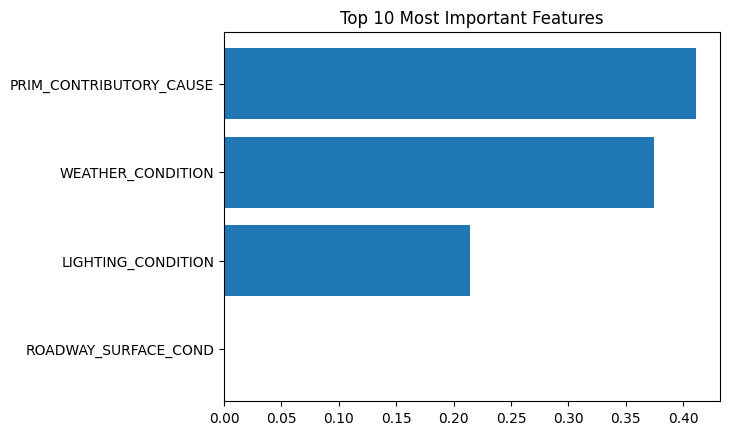

In [78]:
import numpy as np
import matplotlib.pyplot as plt

importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]

plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Top 10 Most Important Features")
plt.show()


## Final Insights

Peak Crash Times: A majority of the accidents take place in the afternoon and early evening, particularly during the commuting hours in the weekdays.

The fact that the behavior of the driver (inability to give way, wrong turns, tail-ganging) is the strongest foreteller of the crash and that lighting and road cover conditions are also important.

Weather Impact: Weather does not play such a significant role as human behavior, but extreme weather conditions (ice, snow, wet roads) make it more dangerous.

Model Performance: The performance of the Random Forest is better than the Logistic Regression, which indicates the significance of interaction and non-linear patterns between features.

Recommendations:

Target traffic policing at risky times.

Organize driver safety campaigns of some of the most common risky behaviors.

Enhance infrastructure (lights, road maintenance) in high accident prone locations.

Conclusion: Crash causation predictive models allow interventions based on data, and this would allow policymakers to prevent crashes and improve road safety in Chicago.

**These insights translate into actionable recommendations for traffic safety planning.**
